# 语言模型和数据集
:label:`sec_language_model`

在 :numref:`sec_text_preprocessing`中，
我们了解了如何将文本数据映射为词元，
以及将这些词元可以视为一系列离散的观测，例如单词或字符。
假设长度为$T$的文本序列中的词元依次为$x_1, x_2, \ldots, x_T$。
于是，$x_t$（$1 \leq t \leq T$）
可以被认为是文本序列在时间步$t$处的观测或标签。
在给定这样的文本序列时，*语言模型*（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

例如，只需要一次抽取一个词元$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$，
一个理想的语言模型就能够基于模型本身生成自然文本。
与猴子使用打字机完全不同的是，从这样的模型中提取的文本
都将作为自然语言（例如，英语文本）来传递。
只需要基于前面的对话片断中的文本，
就足以生成一个有意义的对话。
显然，我们离设计出这样的系统还很遥远，
因为它需要“理解”文本，而不仅仅是生成语法合理的内容。

尽管如此，语言模型依然是非常有用的。
例如，短语“to recognize speech”和“to wreck a nice beach”读音上听起来非常相似。
这种相似性会导致语音识别中的歧义，但是这很容易通过语言模型来解决，
因为第二句的语义很奇怪。
同样，在文档摘要生成算法中，
“狗咬人”比“人咬狗”出现的频率要高得多，
或者“我想吃奶奶”是一个相当匪夷所思的语句，
而“我想吃，奶奶”则要正常得多。

## 学习语言模型

显而易见，我们面对的问题是如何对一个文档，
甚至是一个词元序列进行建模。
假设在单词级别对文本数据进行词元化，
我们可以依靠在 :numref:`sec_sequence`中对序列模型的分析。
让我们从基本概率规则开始：

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

例如，包含了四个单词的一个文本序列的概率是：

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

为了训练语言模型，我们需要计算单词的概率，
以及给定前面几个单词后出现某个单词的条件概率。
这些概率本质上就是语言模型的参数。

这里，我们假设训练数据集是一个大型的文本语料库。
比如，维基百科的所有条目、
[古登堡计划](https://en.wikipedia.org/wiki/Project_Gutenberg)，
或者所有发布在网络上的文本。
训练数据集中词的概率可以根据给定词的相对词频来计算。
例如，可以将估计值$\hat{P}(\text{deep})$
计算为任何以单词“deep”开头的句子的概率。
一种（稍稍不太精确的）方法是统计单词“deep”在数据集中的出现次数，
然后将其除以整个语料库中的单词总数。
这种方法效果不错，特别是对于频繁出现的单词。
接下来，我们可以尝试估计

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

其中$n(x)$和$n(x, x')$分别是单个单词和连续单词对的出现次数。
不幸的是，由于连续单词对“deep learning”的出现频率要低得多，
所以估计这类单词正确的概率要困难得多。
特别是对于一些不常见的单词组合，要想找到足够的出现次数来获得准确的估计可能都不容易。
而对于三个或者更多的单词组合，情况会变得更糟。
许多合理的三个单词组合可能是存在的，但是在数据集中却找不到。
除非我们提供某种解决方案，来将这些单词组合指定为非零计数，
否则将无法在语言模型中使用它们。
如果数据集很小，或者单词非常罕见，那么这类单词出现一次的机会可能都找不到。

一种常见的策略是执行某种形式的*拉普拉斯平滑*（Laplace smoothing），
具体方法是在所有计数中添加一个小常量。
用$n$表示训练集中的单词总数，用$m$表示唯一单词的数量。
此解决方案有助于处理单元素问题，例如通过：

$$
\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}
$$

其中，$\epsilon_1,\epsilon_2$和$\epsilon_3$是超参数。
以$\epsilon_1$为例：当$\epsilon_1 = 0$时，不应用平滑；
当$\epsilon_1$接近正无穷大时，$\hat{P}(x)$接近均匀概率分布$1/m$。
上面的公式是 :cite:`Wood.Gasthaus.Archambeau.ea.2011`
的一个相当原始的变形。

然而，这样的模型很容易变得无效，原因如下：
首先，我们需要存储所有的计数；
其次，这完全忽略了单词的意思。
例如，“猫”（cat）和“猫科动物”（feline）可能出现在相关的上下文中，
但是想根据上下文调整这类模型其实是相当困难的。
最后，长单词序列大部分是没出现过的，
因此一个模型如果只是简单地统计先前“看到”的单词序列频率，
那么模型面对这种问题肯定是表现不佳的。

## 马尔可夫模型与$n$元语法

在讨论包含深度学习的解决方案之前，我们需要了解更多的概念和术语。
回想一下我们在 :numref:`sec_sequence`中对马尔可夫模型的讨论，
并且将其应用于语言建模。
如果$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，
则序列上的分布满足一阶马尔可夫性质。
阶数越高，对应的依赖关系就越长。
这种性质推导出了许多可以应用于序列建模的近似公式：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为
*一元语法*（unigram）、*二元语法*（bigram）和*三元语法*（trigram）模型。
下面，我们将学习如何去设计更好的模型。

## 自然语言统计

我们看看在真实数据上如果进行自然语言统计。
根据 :numref:`sec_text_preprocessing`中介绍的时光机器数据集构建词表，
并打印前$10$个最常用的（频率最高的）单词。


In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，(**最流行的词**)看起来很无聊，
这些词通常(**被称为*停用词***)（stop words），因此可以被过滤掉。
尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。
此外，还有个明显的问题是词频衰减的速度相当地快。
例如，最常用单词的词频对比，第$10$个还不到第$1$个的$1/5$。
为了更好地理解，我们可以[**画出的词频图**]：


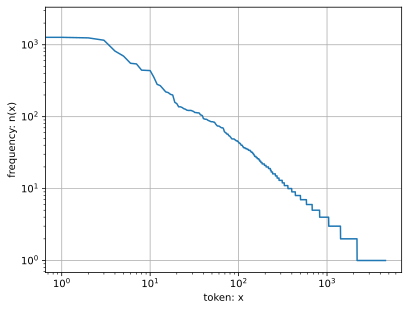

In [3]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

通过此图我们可以发现：词频以一种明确的方式迅速衰减。
将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。
这意味着单词的频率满足*齐普夫定律*（Zipf's law），
即第$i$个最常用单词的频率$n_i$为：

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

等价于

$$\log n_i = -\alpha \log i + c,$$

其中$\alpha$是刻画分布的指数，$c$是常数。
这告诉我们想要通过计数统计和平滑来建模单词是不可行的，
因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。
那么[**其他的词元组合，比如二元语法、三元语法等等，又会如何呢？**]
我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。


In [4]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，
只有一个与“the time”有关。
我们再进一步看看三元语法的频率是否表现出相同的行为方式。


In [5]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，我们[**直观地对比三种模型中的词元频率**]：一元语法、二元语法和三元语法。


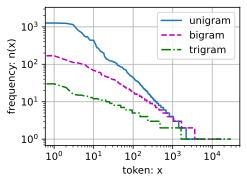

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这张图非常令人振奋！原因有很多：

1. 除了一元语法词，单词序列似乎也遵循齐普夫定律，
尽管公式 :eqref:`eq_zipf_law`中的指数$\alpha$更小
（指数的大小受序列长度的影响）；
2. 词表中$n$元组的数量并没有那么大，这说明语言中存在相当多的结构，
这些结构给了我们应用模型的希望；
3. 很多$n$元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。
作为代替，我们将使用基于深度学习的模型。

## 读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。
在 :numref:`sec_sequence`中我们以一种相当特别的方式做到了这一点：
当序列变得太长而不能被模型一次性全部处理时，
我们可能希望拆分这样的序列方便模型读取。

在介绍该模型之前，我们看一下总体策略。
假设我们将使用神经网络来训练语言模型，
模型中的网络一次处理具有预定义长度
（例如$n$个时间步）的一个小批量序列。
现在的问题是如何[**随机生成一个小批量数据的特征和标签以供读取。**]

首先，由于文本序列可以是任意长的，
例如整本《时光机器》（*The Time Machine*），
于是任意长的序列可以被我们划分为具有相同时间步数的子序列。
当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。
假设网络一次只处理具有$n$个时间步的子序列。
 :numref:`fig_timemachine_5gram`画出了
从原始文本序列获得子序列的所有不同的方式，
其中$n=5$，并且每个时间步的词元对应于一个字符。
请注意，因为我们可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度。

![分割文本时，不同的偏移量会导致不同的子序列](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

因此，我们应该从 :numref:`fig_timemachine_5gram`中选择哪一个呢？
事实上，他们都一样的好。
然而，如果我们只选择一个偏移量，
那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。
因此，我们可以从随机偏移量开始划分序列，
以同时获得*覆盖性*（coverage）和*随机性*（randomness）。
下面，我们将描述如何实现*随机采样*（random sampling）和
*顺序分区*（sequential partitioning）策略。

### 随机采样

(**在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。**)
在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。
对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元，
因此标签是移位了一个词元的原始序列。

下面的代码每次可以从数据中随机生成一个小批量。
在这里，参数`batch_size`指定了每个小批量中子序列样本的数目，
参数`num_steps`是每个子序列中预定义的时间步数。


In [13]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们[**生成一个从$0$到$34$的序列**]。
假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。


In [17]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[14, 15, 16, 17, 18],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])
X:  tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[30, 31, 32, 33, 34],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[24, 25, 26, 27, 28],
        [ 9, 10, 11, 12, 13]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]])


### 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外，
我们还可以[**保证两个相邻的小批量中的子序列在原始序列上也是相邻的**]。
这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。


In [18]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

基于相同的设置，通过顺序分区[**读取每个小批量的子序列的特征`X`和标签`Y`**]。
通过将它们打印出来可以发现：
迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。


In [19]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


现在，我们[**将上面的两个采样函数包装到一个类中**]，
以便稍后可以将其用作数据迭代器。


In [20]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

[**最后，我们定义了一个函数`load_data_time_machine`，
它同时返回数据迭代器和词表**]，
因此可以与其他带有`load_data`前缀的函数
（如 :numref:`sec_fashion_mnist`中定义的
`d2l.load_data_fashion_mnist`）类似地使用。


In [21]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 小结

* 语言模型是自然语言处理的关键。
* $n$元语法通过截断相关性，为处理长序列提供了一种实用的模型。
* 长序列存在一个问题：它们很少出现或者从不出现。
* 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他$n$元语法。
* 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
* 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

## 练习

1. 假设训练数据集中有$100,000$个单词。一个四元语法需要存储多少个词频和相邻多词频率？
1. 我们如何对一系列对话建模？
1. 一元语法、二元语法和三元语法的齐普夫定律的指数是不一样的，能设法估计么？
1. 想一想读取长序列数据的其他方法？
1. 考虑一下我们用于读取长序列的随机偏移量。
    1. 为什么随机偏移量是个好主意？
    1. 它真的会在文档的序列上实现完美的均匀分布吗？
    1. 要怎么做才能使分布更均匀？
1. 如果我们希望一个序列样本是一个完整的句子，那么这在小批量抽样中会带来怎样的问题？如何解决？


[Discussions](https://discuss.d2l.ai/t/2097)
